## Instruction

It is recommended that you run the notebook on **Google colab**, as it had all packages ready to use.

If you are running on your own devices, then make sure you have PyTorch installed.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
import os

In [2]:
cpu_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def plot_1d_pdf(f):
    '''
    Given a PDF function, plot its value on (-10, 10)
    '''
    assert callable(f)
    x = torch.linspace(-10, 10, 1000)
    px = f(x)
    assert all(px >= 0)
    plt.plot(x, px)
    plt.xlabel('x')
    plt.ylabel('p(x)')

def plot_1d_samples(X):
    '''
    Given some samples from a 1-D distribution,
    plot its empirical distribution using kde
    '''
    assert isinstance(X, torch.Tensor)
    assert len(X.shape) == 1
    sns.kdeplot(X)
    plt.xlabel('x')
    plt.ylabel('p(x) (approximated)')

def plot_2d_samples(X):
    assert isinstance(X, torch.Tensor)
    assert len(X.shape) == 2
    sns.kdeplot(x=X[:,0],y=X[:,1], fill=True, thresh=0, levels=100, cmap="mako", cbar=True)
    plt.xlabel('x_0')
    plt.ylabel('x_1')


class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample


def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss


def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()


def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader)).detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()


def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    # plt.close()


def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            if hasattr(model, 'dequantization'):
                if model.dequantization:
                    batch = batch + torch.rand(batch.shape)
            loss = model.forward(batch)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val

## Ancestral sampling

- Implement ancestral sampling for a few distributions using PyTorch distributions (https://pytorch.org/docs/stable/distributions.html)

(a) Use PyTorch distribution to acquire the PDF function (denoted as f) for a Gaussian with mean 0 and variance of 4, and plot the pdf using `plot_1d_pdf(f)`.

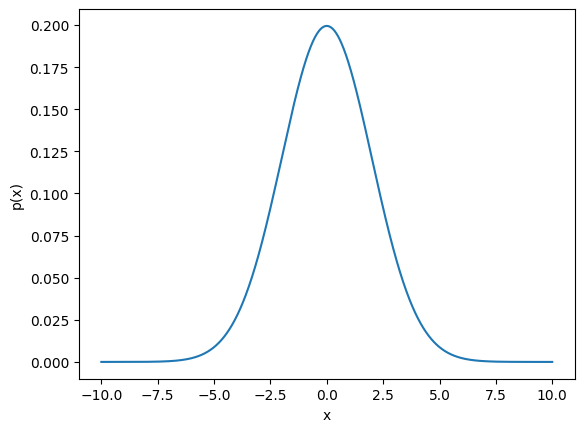

In [4]:
from torch import distributions as distr
def f(x):
    '''
    x: A 1D torch tensor
    Return: A tensor same shape as x that stores the PDF value for each value in x
    '''
    m = distr.normal.Normal(torch.tensor([0.0]), torch.tensor([2.0]))
    return m.log_prob(x).exp()

plot_1d_pdf(f)

(b) Given a model

$$
p(x, z) = p(x \mid z) p(z) \\
p(x \mid z) = N(0, z) \\
p(z) = Exponential(1.0)
$$

Now we draw 5,000 samples from p(x), i.e. the marginal distribution, print out the mean and variance of x using

```python
print('mean: ', x.mean())
print('std: ', x.std())
```

mean:  tensor(-0.0014)
std:  tensor(0.9947)


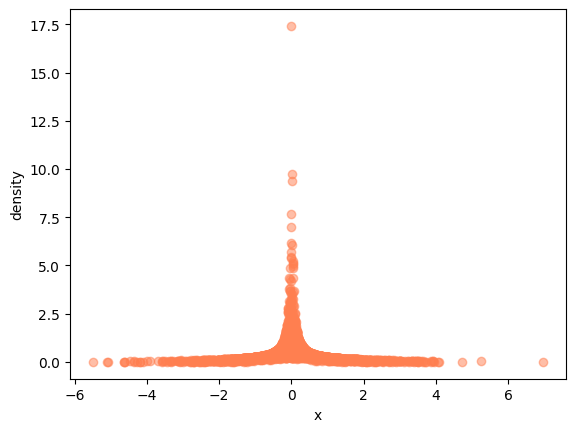

In [5]:
no_samples = 5000
z = distr.Exponential(torch.tensor([1.0]))
z_samples = z.sample(sample_shape = torch.Size([no_samples]))
x_cond_z = distr.normal.Normal(torch.tensor([0.0]), torch.sqrt(z_samples))
x = x_cond_z.sample()
y = x_cond_z.log_prob(x).exp()

print('mean: ', x.mean())
print('std: ', x.std())
plt.scatter(x, y, color='coral', alpha=0.5)
plt.xlabel("x")
plt.ylabel("density")
plt.show()
# plt.xlabel("x")
# plt.ylabel("density")
# plt.plot(x,y)
# plt.show()

(c) Given a 4-component Gaussian mixture, where the components have mean $[-2, -1], [-2, 2], [2, 2], [4, -4]$ and identity matrix as covariance.

The mixing probability of the four component is $[0.2, 0.2, 0.2, 0.4]$.

Now we generate 5000 samples from this mixture model, store the samples in `gmm_samples` and plot it using `plot_2d_samples(gmm_samples)`


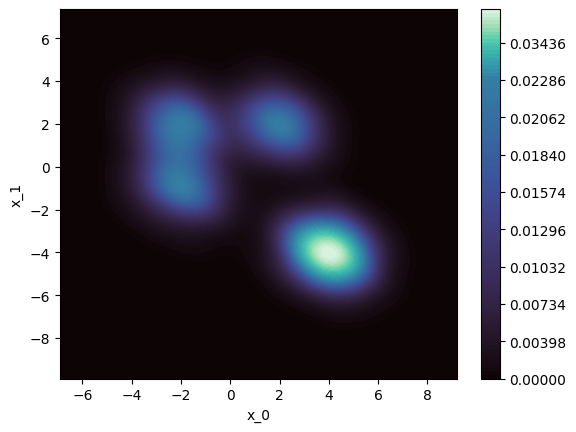

In [6]:
gaussina_components = [distr.multivariate_normal.MultivariateNormal(torch.tensor([-2,-1],dtype=torch.float32), torch.eye(2,dtype=torch.float32)),
                       distr.multivariate_normal.MultivariateNormal(torch.tensor([-2,2],dtype=torch.float32), torch.eye(2,dtype=torch.float32)),
                       distr.multivariate_normal.MultivariateNormal(torch.tensor([2,2],dtype=torch.float32), torch.eye(2,dtype=torch.float32)),
                       distr.multivariate_normal.MultivariateNormal(torch.tensor([4,-4,],dtype=torch.float32), torch.eye(2,dtype=torch.float32))]
mixin_prob = [0.2, 0.2, 0.2, 0.4]
no_samples = 5000
gmm_samples = torch.zeros([5000, 2], dtype=torch.float32)
for i in range(no_samples):
    distribution = np.random.choice(gaussina_components, p=mixin_prob)
    gmm_samples[i] = distribution.rsample()

plot_2d_samples(gmm_samples)

Text(0, 0.5, 'density')

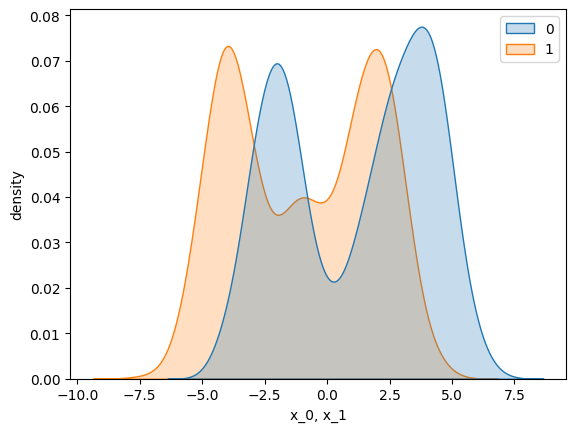

In [7]:
sns.kdeplot(data=gmm_samples, fill=True, thresh=0, levels=100)
plt.xlabel('x_0, x_1')
plt.ylabel('density')

## Simple autoregressive generative model

Implementation of simple autoregressive generative model using **causal convolution**.

In particular, a 1D causal convolution is implemented using PyTorch's Conv1D (https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html).

### (a) Understanding Conv1d

Now assume we have the following code

```python
x = torch.randn(1, 1, D)
y = torch.nn.Conv1d(
    1, 1, kernel_size, dilation=dilation
    stride=1, padding=0)(x)
_, _, output_D = y.shape
```

What is the value of `output_D` given `D, dilation` and `kernel_size`? The functino below implements it.

In [8]:
def compute_output_D(D, kernel_size, dilation):
    output_D = (D - dilation*(kernel_size-1)-1)+1
    return output_D

In [9]:
# Code for verifying the correctness of compute_output_shape,
# run this cell to see if `compute_output_D` matches the output shape
D = 6
input_channel = 1
output_channel = 1
kernel_size = 3
stride=1
padding=0
dilation=2

x = torch.randn(1, 1, D)
y = torch.nn.Conv1d(
    input_channel, output_channel, kernel_size,
    stride=stride, padding=padding, dilation=dilation)(x)

# This assertation should pass if your implementation is correct.
assert compute_output_D(D, kernel_size, dilation) == y.shape[-1]

### (b) Causal convolution with Conv1d

 standard 1D convolution would take the value of the current location for predicting both future locations and past locations. In the figure below, an example is provided where D=4, padding=1, kernel_size=3, dilation=1, and stride=1.

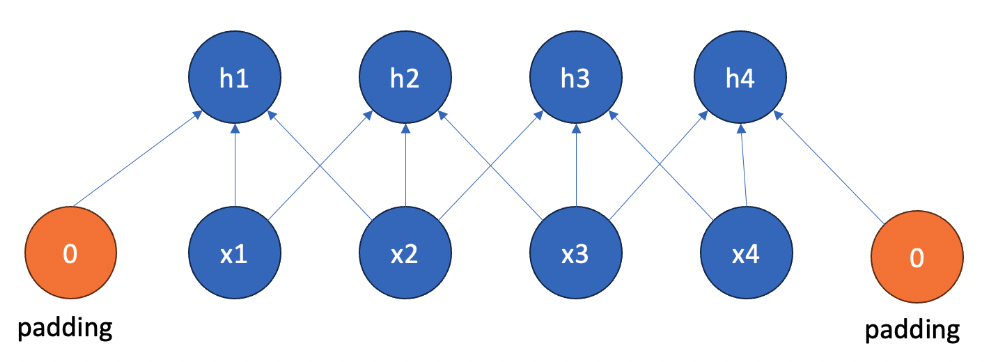

In the figure above, the hidden state at the thrid time step, i.e. h3, is affected by the value from the future: x4. This is not ideal for generative modeling as our objective requires the model to learn to predict the future values given past values, but if the future values are already leaked, then the learning becomes pointless.

To alleviate this issue, Conv1D needs to be turned into a **causal** Conv1d, that is, only the “past” can influence the “future”. In particular, we will utilize padding (rather than masking) here to implement the causal Conv1d.

Here, two different ways are provided on how to implement the causal Conv1d via **padding the inputs**.

**Type A:**

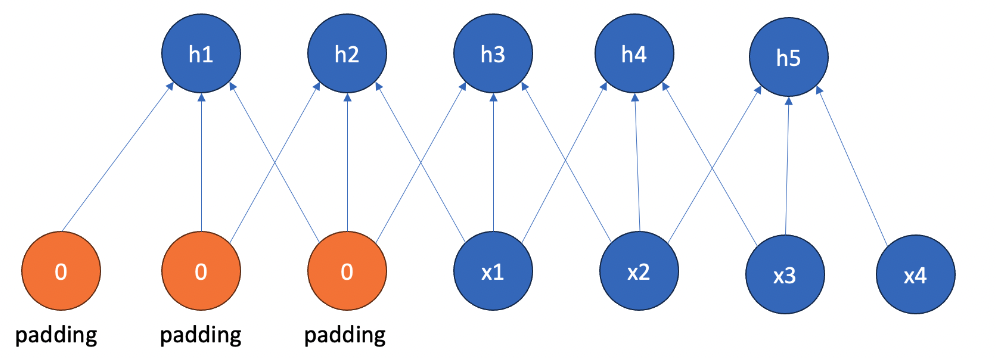

**Type B:**

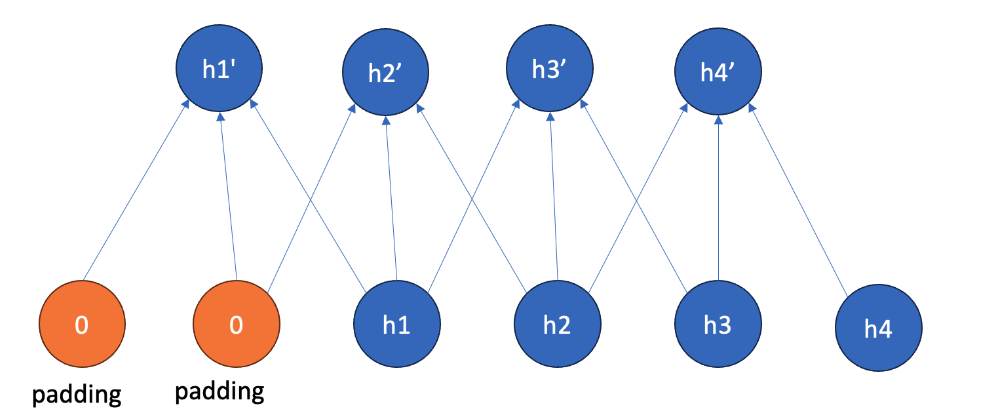

**Difference between the padding strategy used above v.s. PyTorch's padding strategy for Conv1D (e.g. having padding=1)**
```
In causal convolution padding is done before the start of the input whereas in PyTorch's padding strategy the input signal is padded both at the start and the end. For padding=1, in casual case the padded dimnesion of the input increases by 1 as 0 is added before the start. In pytorch implementation the padded dimension increases by 2 as two zeros are added i.e. at the start and end.
```

**Difference between Type A and Type B**
```
In Type B, the hidden dimension is dependent on current and past inputs. In Type A, the hidden dimension is dependent on past inputs only.
```
**Note**
```
If we are using Type A of causal Conv1d, the last hidden state (h5) needs to be dropped if we are using it for autoregressive model. Autogressive models have the same output and input dimension. This is the design assumption for that model. For generation task, it makes sense to produce new samples with the same dimension as the training or input data.
```

### CausalConv1d

In [10]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, typeA=False):
        super(CausalConv1d, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.typeA = typeA # If typeA=True, use TypeA causal conv1d, else use TypeB causal conv1d.

        self.padding = dilation*(kernel_size-1)+1 if typeA else dilation*(kernel_size-1)
        self.conv1d = torch.nn.Conv1d(in_channels, out_channels,
                                      kernel_size, stride=1,
                                      padding=0,
                                      dilation=dilation, bias=True)

    def forward(self, x):
        x = F.pad(x,(self.padding,0), "constant", 0.0) # Pad the input
        conv1d_out = self.conv1d(x)
        if self.typeA:
            return conv1d_out[:,:,:-1] # Drop the last hidden state
        else:
            return conv1d_out

In [11]:
# Tests
x = torch.randn(1, 1, 128)
C = CausalConv1d(1, 1, 10, 2, True)
C.conv1d.weight.data.fill_(1.0)
C.conv1d.bias.data.fill_(0.0)
y = C(x)
assert C.conv1d.padding == (0,)
assert y.shape == x.shape
y = y.squeeze()
x = x.squeeze()
assert 0.0 == y[0].item()
assert y[1].item() == x[0].item()
assert y[2].item() == x[1].item()
print('Test passed')

Test passed


### (c) Stacking CausalConv1D

Now, we will use causal convolution to build a simple autoregressive generative model.

In particular, stack multiple CausalConv1D layers together to build an experssive network.

Below, is a simple example on how to stack CausalConv1D together using nn.Sequential, using LeakyReLU as the activation.

In [12]:
num_vals = 4
kernel_size = 3
M = 32
net = nn.Sequential(
    CausalConv1d(in_channels=1, out_channels=M, dilation=1, kernel_size=kernel_size, typeA=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=M, dilation=2, kernel_size=kernel_size, typeA=False),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=M, dilation=4, kernel_size=kernel_size, typeA=False),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=num_vals, dilation=8, kernel_size=kernel_size, typeA=False)
)

In [13]:
x = torch.randn(128, 1, 64)
t = net(x)
print(t.shape)

torch.Size([128, 4, 64])


### (d) Model - PixelCNN1D

In [14]:
def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    EPS = 1e-9
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1. - EPS))
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


class PixelCNN1D(nn.Module):
    def __init__(self, net, D=2, num_vals=256):
        '''
        net: A network that takes in input of size (B, 1, D) and
            returns real values of shape (B, num_vals, D)
        D: Dimension/Length of the data
        num_vals: Number of possible values for each dimension
        '''
        super(PixelCNN1D, self).__init__()
        self.net = net
        self.num_vals = num_vals
        self.D = D

    def f(self, x):
        '''
        Function to estimate conditional probability density of current pixel value given previous pixels (depends on ordering).
        '''
        h = self.net(x.unsqueeze(1))
        h = h.permute(0, 2, 1)
        p = torch.softmax(h, 2)
        return p

    def forward(self, x, reduction='avg'):
        '''
        Function for forward pass of the model.
        '''
        if reduction == 'avg':
            return -(self.log_prob(x).mean())
        elif reduction == 'sum':
            return -(self.log_prob(x).sum())
        else:
            raise ValueError('reduction could be either `avg` or `sum`.')

    def log_prob(self, x):
        '''
        Evaluate the density of x under the model parameterized by self.net
        '''
        p = self.f(x)
        log_p = log_categorical(x, p, num_classes=self.num_vals, reduction='sum', dim=-1).sum(-1)
        return log_p

    def sample(self, batch_size):
        '''
        Generate batch_size samples from the learned distribution in a *vectorized* way,
        the returned value should be a torch tensor
        '''
        x_new = torch.ones(batch_size, self.D) # initialize the sample tensor
        for d in range(self.D):
            output_probs = self.f(x_new)
            d_sample = torch.multinomial(output_probs[:,d,:], num_samples=1)
            x_new[:,d] = d_sample.T
        return x_new

**Complexity of log_prob and sampling**
```
log_prob can be performed by parallelization/vectorization because the forward propgation f(x) can be computed in-parallel across time steps since x is given.

Sampling cannot be performed by parallelization/vectorization because we have to first sample one time step, and then generate the next-step sample condtioned on this sample. Therefore, it cannot be paralleized across time-step and the complexity would grow linearly with respect to the input dimension(D).
```

### Train

In [15]:
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

result_dir = 'results/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'pixelCNN1D'

D = 64   # input dimension
M = 256

lr = 1e-3 # learning rate
num_epochs = 20 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

likelihood_type = 'categorical'

num_vals = 17

kernel = 7

net = nn.Sequential(
    CausalConv1d(in_channels=1, out_channels=M, dilation=1, kernel_size=kernel, typeA=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=M, dilation=1, kernel_size=kernel, typeA=False),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=M, dilation=1, kernel_size=kernel, typeA=False),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=num_vals, dilation=1, kernel_size=kernel, typeA=False))

model = PixelCNN1D(net, D=D, num_vals=num_vals)
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)
nll_val = training(name=result_dir + name, max_patience=max_patience, num_epochs=num_epochs, model=model, optimizer=optimizer,
                       training_loader=training_loader, val_loader=val_loader)

Epoch: 0, val nll=120.41655343191964
saved!
Epoch: 1, val nll=113.35773995535715
saved!
Epoch: 2, val nll=110.24634905133928
saved!
Epoch: 3, val nll=108.52480747767858
saved!
Epoch: 4, val nll=106.2833154296875
saved!
Epoch: 5, val nll=103.97514439174107
saved!
Epoch: 6, val nll=101.29585239955357
saved!
Epoch: 7, val nll=99.12089564732143
saved!
Epoch: 8, val nll=97.14210170200893
saved!
Epoch: 9, val nll=95.75420968191965
saved!
Epoch: 10, val nll=94.97222516741071
saved!
Epoch: 11, val nll=94.54296735491072
saved!
Epoch: 12, val nll=93.63074358258929
saved!
Epoch: 13, val nll=93.5396484375
saved!
Epoch: 14, val nll=92.92597935267857
saved!
Epoch: 15, val nll=92.68781180245536
saved!
Epoch: 16, val nll=92.50401646205357
saved!
Epoch: 17, val nll=92.2258203125
saved!
Epoch: 18, val nll=91.69727818080356
saved!
Epoch: 19, val nll=91.75055733816964


### Train Loss Curve

FINAL LOSS: nll=88.79163389611297


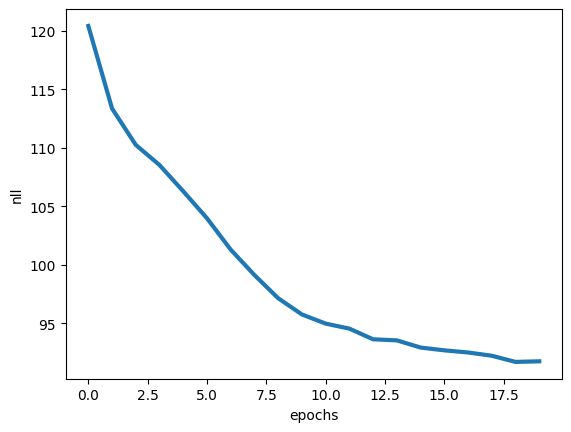

In [16]:
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)

plot_curve(result_dir + name, nll_val)
plt.show()

### (e) Out-of-distribution detection

The learned generative model $p_\theta(\mathbf{x})$ is used to perform out-of-distribution (OOD) detection, that is, identifying data points that deviate significantly from the distribution of the training data. This is crucial in understanding the robustness and reliability of the model in scenarios where it encounters unfamiliar or anomalous data.

In particular, two types of OOD samples are considered: Noise corrupted samples and rotated samples, see below for examples

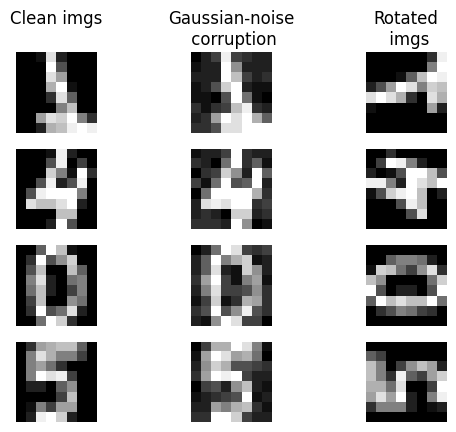

In [17]:
fig, ax = plt.subplots(4, 3)
clean_imgs = val_data[:100]
noise_corrupted_imgs = np.clip((clean_imgs + np.random.binomial(n=5, p=0.4, size=(100, 64))).astype('float32'), 0, 16)
rotated_imgs = np.rot90(clean_imgs.reshape(-1, 8, 8), axes=(1, 2))
for i in range(4):
    ax[i, 0].imshow(clean_imgs[i].reshape(8, 8), cmap='gray')
    ax[i, 1].imshow(noise_corrupted_imgs[i].reshape(8, 8), cmap='gray')
    ax[i, 2].imshow(rotated_imgs[i].reshape(8, 8), cmap='gray')

for a in ax.flatten():
    a.set_axis_off()

ax[0, 0].set_title('Clean imgs\n')
ax[0, 1].set_title('Gaussian-noise\n corruption')
ax[0, 2].set_title('Rotated\n imgs')

clean_imgs = torch.from_numpy(clean_imgs)
noise_corrupted_imgs = torch.from_numpy(noise_corrupted_imgs).reshape(-1,64)
rotated_imgs = torch.from_numpy(np.copy(rotated_imgs)).reshape(-1, 64)

**Density Plots:**

To compute the **log density** of `clean_imgs`, `noise_corrupted_imgs` and `rotated_imgs` using learned PixelCNN1D model

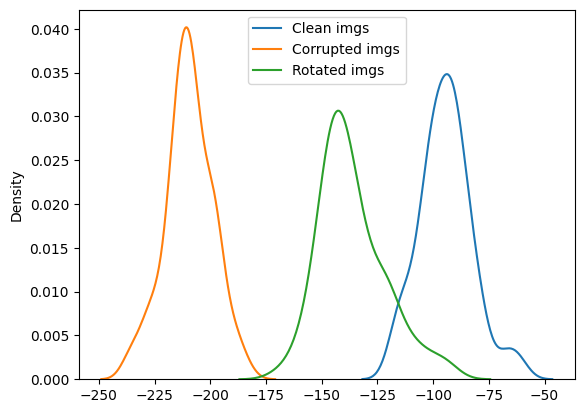

In [18]:
with torch.autograd.no_grad():
    clean_density = model.log_prob(clean_imgs)
    corrupted_img_density = model.log_prob(noise_corrupted_imgs)
    rotated_img_density = model.log_prob(rotated_imgs)

# Code for plotting density
sns.kdeplot(clean_density.numpy(), label='Clean imgs')
sns.kdeplot(corrupted_img_density.numpy(), label='Corrupted imgs')
sns.kdeplot(rotated_img_density.numpy(), label='Rotated imgs')
plt.legend()

**To detect these "corrputed" samples or abnormal samples in real world applications:**
```
1. We can compute the log prob using the model for new samples. If the log probability is low then can either be outliers or OOD.
2. We can set a threshold based on the log density distributions. If we get samples with log densities below the threshold the can be detected as ood.
```